<a href="https://colab.research.google.com/github/PARTHIBAN-007/Vision-Transformer-From-Scratch/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader

In [84]:
batch_size = 64
img_size = 28
patch_size = 7
num_channels = 1
num_patches = (img_size//patch_size)**2
num_heads = 1
embed_dim = 16
mlp_dim = 16
transformer_units = 1

transform = transforms.Compose(
    [transforms.ToTensor()]
)

In [85]:
train_set =  torchvision.datasets.MNIST(root = "./data",train = True,download = True,transform = transform)
val_set =  torchvision.datasets.MNIST(root = "./data",train = False,download = True,transform = transform)

In [86]:
train_data = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_data = DataLoader(val_set,batch_size=batch_size,shuffle=False)

In [87]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels,embed_dim, kernel_size=patch_size,stride = patch_size)

  def forward(self,x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x

In [88]:
class TransformerArchitecture(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.self_attention = nn.MultiheadAttention(embed_dim,num_heads,batch_first = True)
    self.layer_norm2 = nn.LayerNorm(embed_dim)
    self.multi_layer_preceptron = nn.Sequential(
        nn.Linear(embed_dim,mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim,embed_dim)
    )

  def forward(self,x):
    residual_1 = x
    attention_output = self.self_attention(self.layer_norm1(x),self.layer_norm1(x),self.layer_norm1(x))[0]
    x = attention_output + residual_1
    residual_2 = x
    mlp_output = self.multi_layer_preceptron(self.layer_norm2(x))
    x = mlp_output + residual_2
    return x

In [89]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1,(img_size//patch_size)**2 + 1, embed_dim))
    self.transformer_layers = nn.Sequential(
        *[TransformerArchitecture() for _ in range(transformer_units)]
    )

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim,10)
    )

  def forward(self,x):
    x = self.patch_embedding(x)
    B = x.size(0)

    cls_tokens = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_tokens,x),dim=1)
    x = x + self.pos_embed
    x = self.transformer_layers(x)
    x = x[:,0]
    x = self.mlp_head(x)
    return x


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [91]:
for epoch in range(10):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"Epoch : {epoch+1}")

  for batch_idx, (images,labels) in enumerate(train_data):
    images,labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)

    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    preds = outputs.argmax(dim=1)

    correct = (preds==labels).sum().item()
    accuracy = 100.0 * correct / labels.size(0)

    correct_epoch += correct
    total_epoch += labels.size(0)

    if batch_idx%100==0:
      print(f"Batch {batch_idx+1} : Loss = {loss.item():.4f}, Accuracy : {accuracy:.2f}")
  epoch_acc = 100.0 * correct_epoch /total_epoch
  print(f"Epoch {epoch+1}  Summary : Total Loss : {total_loss:.4f}, Accuracy = {epoch_acc:.2f}")






Epoch : 1
Batch 1 : Loss = 2.3869, Accuracy : 4.69
Batch 101 : Loss = 1.2741, Accuracy : 57.81
Batch 201 : Loss = 0.9464, Accuracy : 70.31
Batch 301 : Loss = 0.9103, Accuracy : 70.31
Batch 401 : Loss = 0.8190, Accuracy : 68.75
Batch 501 : Loss = 0.7707, Accuracy : 79.69
Batch 601 : Loss = 0.5774, Accuracy : 79.69
Batch 701 : Loss = 0.7921, Accuracy : 73.44
Batch 801 : Loss = 0.4876, Accuracy : 87.50
Batch 901 : Loss = 0.3755, Accuracy : 87.50
Epoch 1  Summary : Total Loss : 710.6382, Accuracy = 74.40
Epoch : 2
Batch 1 : Loss = 0.5290, Accuracy : 82.81
Batch 101 : Loss = 0.2420, Accuracy : 92.19
Batch 201 : Loss = 0.5729, Accuracy : 81.25
Batch 301 : Loss = 0.3320, Accuracy : 89.06
Batch 401 : Loss = 0.5156, Accuracy : 85.94
Batch 501 : Loss = 0.4065, Accuracy : 87.50
Batch 601 : Loss = 0.6431, Accuracy : 78.12
Batch 701 : Loss = 0.4380, Accuracy : 85.94
Batch 801 : Loss = 0.3259, Accuracy : 87.50
Batch 901 : Loss = 0.4411, Accuracy : 85.94
Epoch 2  Summary : Total Loss : 424.7512, Accu

In [92]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images,labels in val_data:
    images, labels = images.to(device) , labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)
    correct += (preds==labels).sum().item()
    total += labels.size(0)
  val_acc = 100.0 * correct/total
  print(f"Validation Accuracy: { val_acc:.2f}")



Validation Accuracy: 91.16


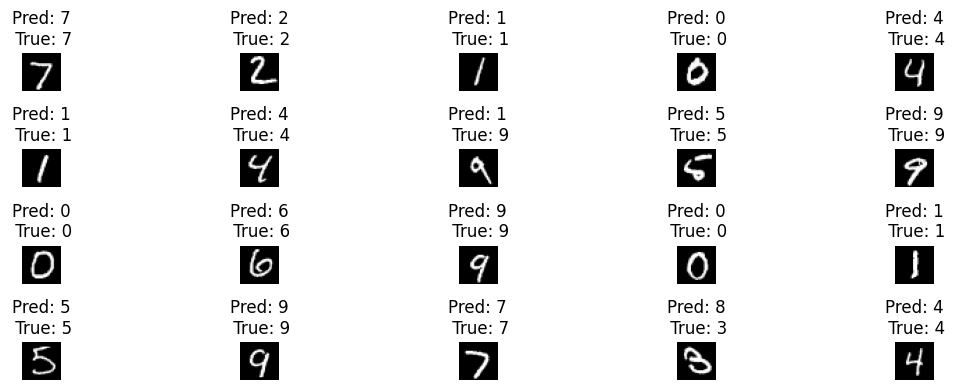

In [93]:
model.eval()
images , labels = next(iter(val_data))
images, labels = images.to(device) , labels.to(device)

with torch.no_grad():
  outputs = model(images)
  preds = outputs.argmax(dim=1)


plt.figure(figsize = (12,4))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(images[i].squeeze(),cmap = "grey")
  plt.title(f"Pred: {preds[i].item()}\n True: {labels[i].item()}")
  plt.axis("off")
plt.tight_layout()
plt.show()

In [94]:
# Manual Checking of Image Transformations in the Vision transformer


images , labels= next(iter(val_data))

print(f"Shape of the image data in batch : {images.shape}")
patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size=patch_size,stride = patch_size)
embedded_data = patch_embed(images)
embedded_data = embedded_data.flatten(2)
embedded_data = embedded_data.transpose(1,2)
print(f"shape of Embedded Data:  {embedded_data.shape}")
print(torch.randn(1,1,embed_dim).shape)

Shape of the image data in batch : torch.Size([64, 1, 28, 28])
shape of Embedded Data:  torch.Size([64, 16, 16])
torch.Size([1, 1, 16])


In [95]:
print(f"Batch Size: {batch_size}")
print(f"Image Size: {img_size}")
print(f"Patch Size: {patch_size}")
print(f"Number of Channels: {num_channels}")
print(f"Number of Patches: {num_patches}")
print(f"Number of Heads: {num_heads}")
print(f"Embedding Dimension: {embed_dim}")
print(f"MLP Dimension: {mlp_dim}")
print(f"Number of Transformer Units: {transformer_units}")

Batch Size: 64
Image Size: 28
Patch Size: 7
Number of Channels: 1
Number of Patches: 16
Number of Heads: 1
Embedding Dimension: 16
MLP Dimension: 16
Number of Transformer Units: 1
